<a href="https://colab.research.google.com/github/gurpreet1998/EWC---NN-Forgetting/blob/master/EWC_implementation_saved_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import files

In [0]:
uploaded = files.upload()

Saving model.py.zip to model.py.zip


In [0]:
!unzip model.py.zip

Archive:  model.py.zip
  inflating: model.py                


In [0]:
from model import Model

In [0]:
# automatically reload edited modules
%load_ext autoreload
%autoreload 2


In [0]:
import tensorflow as tf
import numpy as np
from copy import deepcopy


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython import display


In [0]:
def mnist_imshow(img):
    plt.imshow(img.reshape([28,28]), cmap="gray")
    plt.axis('off')

# return a new mnist dataset w/ pixels randomly permuted

In [0]:
# classification accuracy plotting
def plot_test_acc(plot_handles):
    plt.legend(handles=plot_handles, loc="center right")
    plt.xlabel("Iterations")
    plt.ylabel("Test Accuracy")
    plt.ylim(0,1)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
    
# train/compare vanilla sgd and ewc
def train_task(model, num_iter, disp_freq, trainset, testsets, x, y_, lams=[0]):
    for l in range(len(lams)):
        # lams[l] sets weight on old task(s)
        model.restore(sess) # reassign optimal weights from previous training session
        if(lams[l] == 0):
            model.set_vanilla_loss()
        else:
            model.update_ewc_loss(lams[l])
        # initialize test accuracy array for each task 
        test_accs = []
        for task in range(len(testsets)):
            test_accs.append(np.zeros(int(num_iter/disp_freq)))
        # train on current task
        for iter in range(num_iter):
            batch = trainset.train.next_batch(128)
            model.train_step.run(feed_dict={x: batch[0], y_: batch[1]})
            if iter % disp_freq == 0:
                plt.subplot(1, len(lams), l+1)
                plots = []
                colors = ['r', 'b', 'g']
                for task in range(len(testsets)):
                    feed_dict={x: testsets[task].test.images, y_: testsets[task].test.labels}
                    test_accs[task][int(iter/disp_freq)] = model.accuracy.eval(feed_dict=feed_dict)
                    c = chr(ord('A') + task)
                    plot_h, = plt.plot(range(1,iter+2,disp_freq), test_accs[task][:int(iter/disp_freq+1)], colors[task], label="task " + c)
                    plots.append(plot_h)
                plot_test_acc(plots)
                if l == 0: 
                    plt.title("vanilla sgd")
                else:
                    plt.title("ewc")
                plt.gcf().set_size_inches(len(lams)*5, 3.5)
        plt.savefig('task1.png')
        files.download("task1.png") 
        

In [0]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fr

In [0]:
fashion_mnist = input_data.read_data_sets('data/fashion', source_url='http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/',one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 26421880 bytes.
Extracting data/fashion/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 29515 bytes.
Extracting data/fashion/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 4422102 bytes.
Extracting data/fashion/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 5148 bytes.
Extracting data/fashion/t10k-labels-idx1-ubyte.gz


In [0]:
sess = tf.InteractiveSession()


In [0]:
# define input and target placeholders
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])


In [0]:
# instantiate new model
model = Model(x, y_) # simple 2-layer network

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [0]:
# initialize variables
sess.run(tf.global_variables_initializer())

## train on task A, test on task A

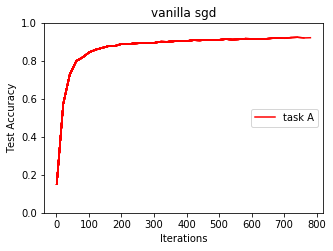

In [0]:
# training 1st task
train_task(model, 800, 20, mnist, [mnist], x, y_, lams=[0])

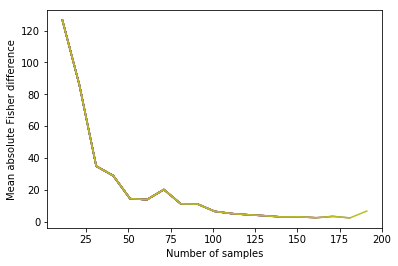

In [0]:
# Fisher information
model.compute_fisher(mnist.validation.images, sess, num_samples=200, plot_diffs=True) # use validation set for Fisher computation


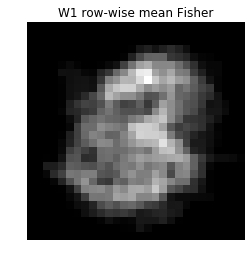

In [0]:
F_row_mean = np.mean(model.F_accum[0], 1)
mnist_imshow(F_row_mean)
plt.title("W1 row-wise mean Fisher");

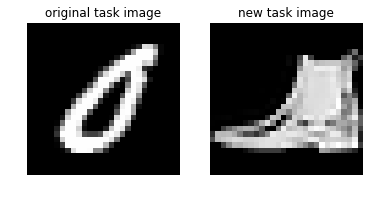

In [0]:
# 2nd task
mnist2 = fashion_mnist

plt.subplot(1,2,1)
mnist_imshow(mnist.train.images[5])
plt.title("original task image")
plt.subplot(1,2,2)
mnist_imshow(mnist2.train.images[5])
plt.title("new task image");


In [0]:
# save current optimal weights
model.star()


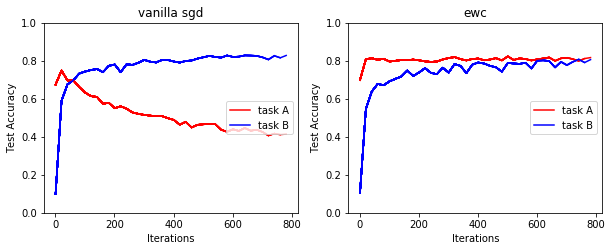

In [0]:
# training 2nd task
train_task(model, 800, 20, mnist2, [mnist, mnist2], x, y_, lams=[0,15])

In [0]:
# Shapes of training set
print("Training set (images) shape: {shape}".format(shape=fashion_mnist.train.images.shape))
print("Training set (labels) shape: {shape}".format(shape=fashion_mnist.train.labels.shape))

# Shapes of test set
print("Test set (images) shape: {shape}".format(shape=fashion_mnist.test.images.shape))
print("Test set (labels) shape: {shape}".format(shape=fashion_mnist.test.labels.shape))

Training set (images) shape: (55000, 784)
Training set (labels) shape: (55000, 10)
Test set (images) shape: (10000, 784)
Test set (labels) shape: (10000, 10)


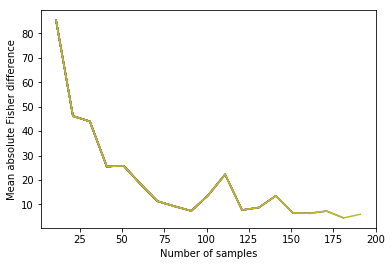

In [0]:
# Fisher information for 2nd task
model.compute_fisher(mnist2.validation.images, sess, num_samples=200, plot_diffs=True)

In [0]:
plt.savefig('fish.png')
files.download('fish.png')

<Figure size 432x288 with 0 Axes>

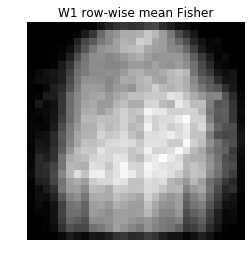

In [0]:
F_row_mean = np.mean(model.F_accum[0], 1)
mnist_imshow(F_row_mean)
plt.title("W1 row-wise mean Fisher");


In [0]:
# save current optimal weights
model.star()
